
# Will your next operation get cancelled?


## 1. Setting Up The Notebook

The data for this project were first published by Public Health Scotland in 2019 and last updated on the 20th of July 2022. They are freely available [here](https://www.opendata.nhs.scot/dataset/cancelled-planned-operations/resource/bcc860a4-49f4-4232-a76b-f559cf6eb885) and [here](https://www.opendata.nhs.scot/en_GB/dataset/hospital-codes). Some [initial analysis](https://publichealthscotland.scot/publications/cancelled-planned-operations/cancelled-planned-operations-month-ending-31-may-2022/) on this dataset has already been conducted by Public Health Scotland, but I have not seen or read any reports that go beyond this.

In this first step we will read in the data and import any required libraries.


In [33]:
# Import the necessary libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.figure as fig
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

In [34]:
# Load the data
data_raw = pd.read_csv("Cancellations.csv")
hospitals = pd.read_csv("Hospitals.csv")


## 2. Having a First Look at the Data


In [35]:
# Inspect the shape of the data
print("The dataset has",data_raw.shape[0],"rows and", data_raw.shape[1], "columns")
data_raw.head()

The dataset has 3683 rows and 15 columns


,_id,Month,Hospital,TotalOperations,TotalOperationsQF,TotalCancelled,TotalCancelledQF,CancelledByPatientReason,CancelledByPatientReasonQF,ClinicalReason,ClinicalReasonQF,NonClinicalCapacityReason,NonClinicalCapacityReasonQF,OtherReason,OtherReasonQF
0,1,201505,D102H,1274,NaN,57,NaN,20,NaN,7,NaN,30,NaN,0,NaN
1,2,201505,A111H,884,NaN,67,NaN,21,NaN,25,NaN,16,NaN,5,NaN
2,3,201505,A210H,977,NaN,111,NaN,31,NaN,45,NaN,11,NaN,24,NaN
3,4,201505,B120H,457,NaN,66,NaN,11,NaN,10,NaN,45,NaN,0,NaN
4,5,201505,Y104H,1312,NaN,100,NaN,27,NaN,54,NaN,10,NaN,9,NaN


Based on the first few rows of the columns, we can already tell that we can drop the  _id column, as it fulfills the same function as the index. From these first rows it also appears as if the qualifier columns with the suffix QF seem to contain largely NaNs. Let's investigate this further, and see where else in this dataset we might have missing data!

In [36]:
# The best way to see how much of each column is missing is by visualising it! 
# First, we need to extract the data we want to visualise:
missing = data_raw.isna().mean().sort_values()
print(missing)

_id                            0.0
Month                          0.0
Hospital                       0.0
TotalOperations                0.0
TotalCancelled                 0.0
CancelledByPatientReason       0.0
ClinicalReason                 0.0
NonClinicalCapacityReason      0.0
OtherReason                    0.0
TotalOperationsQF              1.0
TotalCancelledQF               1.0
CancelledByPatientReasonQF     1.0
ClinicalReasonQF               1.0
NonClinicalCapacityReasonQF    1.0
OtherReasonQF                  1.0
dtype: float64


A quick look at the output already tells us that there is no need for further visualisation! All the qualifier columns do not contain a single entry. This is good news, as it means that the publisher has no reservations on these datapoints, and we can happily drop the qualifier columns. It is time to start building our data cleaning function.

## 3. Data Cleaning
For cleaning the data we will create a function, which takes the raw data as its input, performs any cleaning operations we want to do, and returns a clean data frame. We have already seen that we should drop the _ id column and the qualifier columns as they contain no valuable information for us. We also see, that the Month column is currently saved as an integer value comprising the year in the first 4 digit and the month in the last two. To give us more flexibility when analysing the data, we will create two new columns: The month (as a string), and the year (as an integer)

In [37]:
# Define the function:

def cancellation_cleaning(data_raw):
    # Drop na columns and the id column
    data = data_raw.dropna(axis = 1)
    data = data.drop('_id', axis = 1)
    
    #split the Month column into Month and Year
    data['Month'] = data['Month'].astype('str')

    year_generator = lambda year: year[:4]
    data['Year'] = data['Month'].apply(year_generator)
    data['Year'] = data['Year'].astype('int')

    month_generator = lambda month: month[4:]
    data['Month_str'] = data['Month'].apply(month_generator)
    
    return data
    

In [38]:
# Apply the function
data = cancellation_cleaning(data_raw)
data.head()

,Month,Hospital,TotalOperations,TotalCancelled,CancelledByPatientReason,ClinicalReason,NonClinicalCapacityReason,OtherReason,Year,Month_str
0,201505,D102H,1274,57,20,7,30,0,2015,05
1,201505,A111H,884,67,21,25,16,5,2015,05
2,201505,A210H,977,111,31,45,11,24,2015,05
3,201505,B120H,457,66,11,10,45,0,2015,05
4,201505,Y104H,1312,100,27,54,10,9,2015,05


Unfortunately, we can see that the hospital is denoted using a 5 digit code. This is convenient for working with the data, but will make it a lot harder to extract real meaning from it. We therefore imported a second data_frame containing data on the hospitals including their real names and we will now merge the two.

In [39]:
# Making sure both code columns have the same name to make merging easier.
hospitals.rename({'Location':'Hospital'}, axis = 1, inplace = True)
# Dropping any missing values
hospitals = hospitals.dropna(axis = 1)
# Merging
data = pd.merge(data, hospitals, how = 'left', on = 'Hospital')
data.head()

,Month,Hospital,TotalOperations,TotalCancelled,CancelledByPatientReason,ClinicalReason,NonClinicalCapacityReason,OtherReason,Year,Month_str,_id,LocationName,Postcode,AddressLine,HB
0,201505,D102H,1274,57,20,7,30,0,2015,05,240.0,Golden Jubilee National Hospital,G81 4DY,"Agamemnon Street, Clydebank",SB0801
1,201505,A111H,884,67,21,25,16,5,2015,05,5.0,University Hospital Crosshouse,KA2 0BE,"Kilmarnock Road, Kilmarnock, Ayrshire",S08000015
2,201505,A210H,977,111,31,45,11,24,2015,05,11.0,University Hospital Ayr,KA6 6DX,"Dalmellington Road, Ayr",S08000015
3,201505,B120H,457,66,11,10,45,0,2015,05,23.0,Borders General Hospital,TD6 9BS,Melrose,S08000016
4,201505,Y104H,1312,100,27,54,10,9,2015,05,NaN,NaN,NaN,NaN,NaN


In [40]:
# We will also create a smaller version, containing only the names and code. This will avoid introducing unwanted columns in the future.
hospital_names = pd.DataFrame({'Hospital':hospitals['Hospital'], 'Location':hospitals['LocationName']})
hospital_names

,Hospital,Location
0,A101H,Arran War Memorial Hospital
1,A103H,Ayrshire Central Hospital
2,A105H,Kirklandside Hospital
3,A110H,Lady Margaret Hospital
4,A111H,University Hospital Crosshouse
...,...,...
272,T324H,Dudhope Young Peoples Inpatient Unit
273,T325H,CAMHS Hospital Unit
274,W106H,St Brendans Cot Hospital
275,W107H,Western Isles Hospital


While we did get rid of any NAs in the dataset, this is still no guarantee that the data is complete. Let's investigate whether we actually have the data for all the hospitals over all the months:

The total number of months in this dataset is: 86
30 Of the hospitals in the dataset have data for all months.
Most hospitals have data for 86 months.


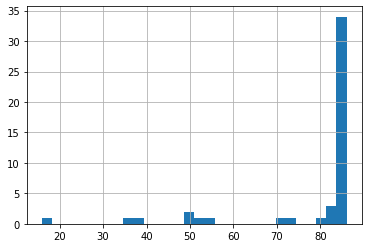

In [41]:
Hospitals = []
for hospital in data['Hospital'].unique():
    n_months = data[data['Hospital'] == hospital].shape[0]
    Hospitals.append(n_months)

Completeness = pd.Series(data = Hospitals, index = data['Hospital'].unique())
Completeness.hist(bins = 30)
print('The total number of months in this dataset is:',Completeness.max())
print(Completeness[Completeness == Completeness.max()].shape[0],'Of the hospitals in the dataset have data for all months.')
print('Most hospitals have data for', Completeness.mode()[0],'months.')

As we can see, we actually only have the complete data for 30 of the hospitals. Now, this gives us multiple options:
1. Remove the hospitals below a certain threshold of completeness and potentially all that have values missing
2. Try and introduce new data where it is currently missing. This could be done for example by taking the mean of this hospital's data adjacent data, or by using more complex methods such as K nearest neighbours
3. Finally, we could accept that we have incomplete data, but ensure we take this into account when analysing our findings

To be able to decide on the right course of action, let's investigate the issue a little bit further:

In [42]:
# Firstly, let us see which hospitals have the most missing months and whether there might be a reason for that
print(Completeness.sort_values().head())
print('The hospital with the most months missing is the', hospital_names.loc[hospital_names['Hospital'] == 'S319H']['Location'])

data[data['Hospital'] == 'S319H']['Month']

S319H    16
Y104H    35
R103H    37
R101H    49
Y177C    50
dtype: int64
The hospital with the most months missing is the 236    Royal Hospital for Children and Young People
Name: Location, dtype: object


3047    202104
3090    202105
3132    202106
3173    202107
3215    202108
3251    202109
3327    202110
3328    202110
3377    202103
3424    202111
3466    202112
3508    202201
3550    202202
3592    202203
3640    202204
3676    202205
Name: Month, dtype: object

So we can see that the hospital with the most missing months is the Royal Hospital for Children and Young People, and that the data for that hospital only start in April of 2021. Now, a quick google search reveals that the hospital was only opened in 2021 which explains why there were no earlier data. In this case imputing data where there are missing would be wrong and it highlights that there might be good reasons why the data are missing and unless we examine each case on its own we couldn't be sure that imputing would be appropriate here. The best option therefore seems to be to keep the incompleteness of the data set in mind, and accordingly remove affected hospitals where required.

## 4. Have cancellations for capacity reasons gotten worse?

The initial analysis done by Public Health Scotland already gives us an indication to answer this, as their report includes conclusions on the development of the total number of cancellations over time, as well as a graph which plots the number of  planned operations and the number of cancellations for each type over time. To really answer the question whether cancellations for capacity reasons have gotten worse though, we want to look at the trend of the % of all planned operations that were cancelled due to capacity.

In [43]:

grouped_data = data.groupby(by ='Month').sum().sort_values(by='Month')
grouped_data.drop(columns = ['Year'], inplace = True)
grouped_data['%_Capacity_Planned'] = (grouped_data['NonClinicalCapacityReason']/grouped_data['TotalOperations'])*100



First, let's plot this to get a first impression.

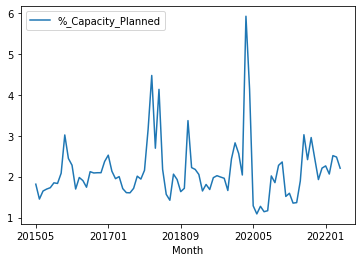

In [44]:
grouped_data.plot(y = '%_Capacity_Planned');

Interesting! There are a lot of ups and downs, but it is difficult to identify any long-term patterns. Getting a lower resolution of the data might be helpful. To make sure we capture any seasonality which we might reasonably expect to be present, we should look at this on a yearly basis. Let's have a look at the date range in our dataset:

In [45]:
print("The first month in the dataset is", grouped_data.index[0])
print("The last month in the dataset is", grouped_data.index[-1])
print("The dataset includes", grouped_data.shape[0], "months, equalling", grouped_data.shape[0]/12, "years.")

The first month in the dataset is 201505
The last month in the dataset is 202205
The dataset includes 85 months, equalling 7.083333333333333 years.


As we can see, the dataset starts and ends in May. We can therefore not simply use calendar years, but have bin the data, making sure each bin contains 12 months. To make sure we include the most recent data available, we will have to drop the oldest data point from May 2015.

In [46]:
annual_data = grouped_data.drop('201505', axis = 0)
periods = ['2015/16','2016/17','2017/18','2018/19','2019/20','2020/21','2021/22']
annual_data['Month'] = annual_data.index.astype('int')
annual_data['Period'] = pd.cut(annual_data['Month'], bins = 7, labels = periods)
annual_data = annual_data.drop('Month', axis =1)
annual_data = annual_data.groupby(by = 'Period').sum()
annual_data['%_Capacity_Planned'] = (annual_data['NonClinicalCapacityReason']/annual_data['TotalOperations'])*100

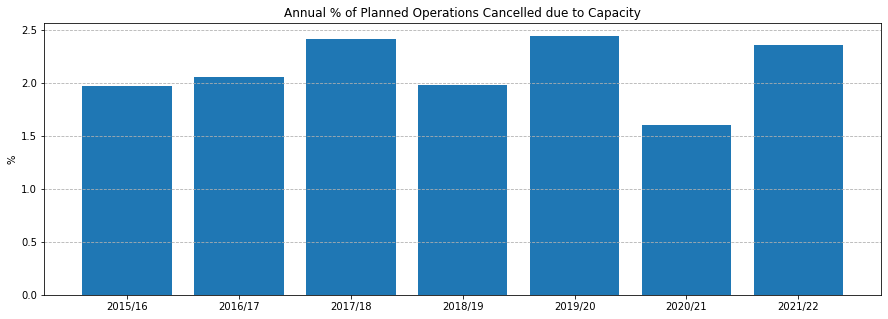

In [47]:
plt.figure(figsize = (15,5))

plt.bar(x = annual_data.index, height = annual_data['%_Capacity_Planned'])
plt.title('Annual % of Planned Operations Cancelled due to Capacity') 
plt.ylabel('%')
plt.grid(axis = 'y', which = 'both', linestyle = '--')
plt.savefig("timeseries.png", format = 'png', dpi = 200)
plt.show();

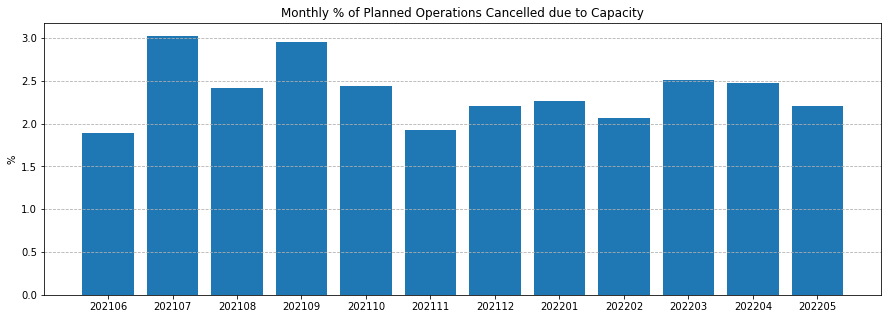

In [48]:
last_12_months = grouped_data[-12:]
plt.figure(figsize = (15,5))

plt.bar(x = last_12_months.index, height = last_12_months['%_Capacity_Planned'])
plt.title('Monthly % of Planned Operations Cancelled due to Capacity') 
plt.ylabel('%')
plt.grid(axis = 'y', which = 'both', linestyle = '--')
plt.savefig("timeseries.png", format = 'png', dpi = 200)
plt.show();

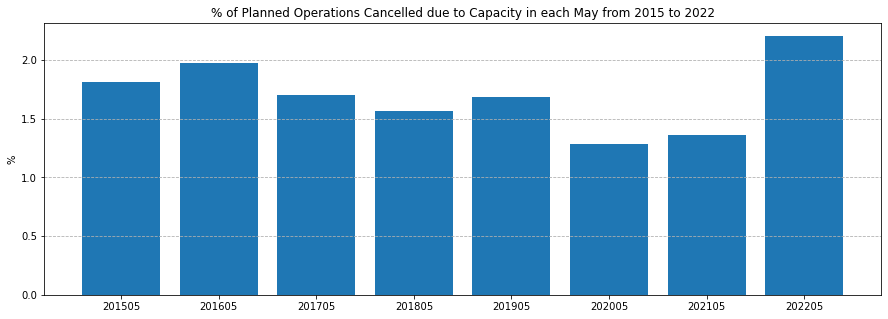

In [49]:
month_generator = lambda month: month[4:]
grouped_data['Month_str'] = grouped_data.index
grouped_data['Month_str'] = grouped_data['Month_str'].apply(month_generator)
may_data = grouped_data[grouped_data['Month_str'] == '05']

plt.figure(figsize = (15,5))

plt.bar(x = may_data.index, height = may_data['%_Capacity_Planned'])
plt.title('% of Planned Operations Cancelled due to Capacity in each May from 2015 to 2022') 
plt.ylabel('%')
plt.grid(axis = 'y', which = 'both', linestyle = '--')
plt.savefig("timeseries.png", format = 'png', dpi = 200)
plt.show();

We can see that both lines follow a similar pattern. There does not seem to be an overall increase in either measure so far in 2022.

## 5. Does it matter which hospital you go to?

So far, we have taken a look at the Scotland-wide trends. However, for most of us only the situation at our local hospital will have a real impact on our lives. Let's therefore take a look at how the different hospitals performed, taking into account data all the way back to 2015. Which hospitals did best and which did worst in the long run?

The 5 hospitals with the highest % of Operations getting cancelled for capacity reasons are:     %PlannedCapacity                                      Location Hospital
17          5.337992                             Raigmore Hospital    H202H
2           4.845708                      Borders General Hospital    B120H
8           3.574666                             Victoria Hospital    F704H
22          3.363026                      Aberdeen Royal Infirmary    N101H
35          3.179510  Royal Hospital for Children and Young People    S319H

The 5 hospitals with the lowest % of Operations getting cancelled for capacity reasons are:     %PlannedCapacity                        Location Hospital
25          0.044563     Aberdeen Maternity Hospital    N161H
4           0.511347  Vale of Leven General Hospital    C206H
12          0.516589           New Victoria Hospital    G306H
45          0.670038                             NaN    Y177C
39          0.739729      Falkirk Community Hosp

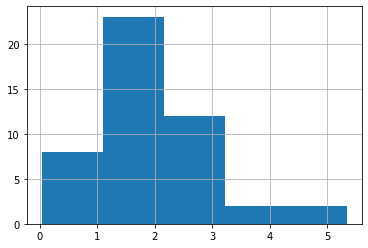

In [50]:
hospital_data = data.groupby(by = ['Hospital']).sum()
hospital_data = hospital_data.drop('Year', axis = 1)
hospital_data = pd.merge(hospital_data, hospital_names, how = 'left', on = 'Hospital')

hospital_data['%PlannedCapacity'] = (hospital_data['NonClinicalCapacityReason']/hospital_data['TotalOperations'])*100
print('The 5 hospitals with the highest % of Operations getting cancelled for capacity reasons are:', hospital_data.sort_values(by = '%PlannedCapacity', ascending = False).head()[['%PlannedCapacity', 'Location', 'Hospital']])
print('')
print('The 5 hospitals with the lowest % of Operations getting cancelled for capacity reasons are:', hospital_data.sort_values(by = '%PlannedCapacity', ascending = True).head()[['%PlannedCapacity', 'Location', 'Hospital']])
hospital_data['%PlannedCapacity'].hist(bins = 5);
print('There are', hospital_data.shape[0], 'hospitals in the dataset.')

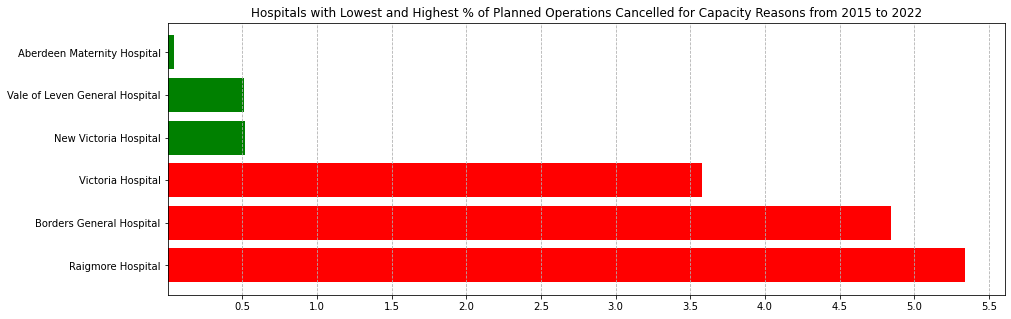

In [51]:
bot3 = hospital_data['%PlannedCapacity'].nlargest(3)
top3 = hospital_data['%PlannedCapacity'].nsmallest(3)
Extremes = pd.concat([top3,bot3])
Extremes = pd.concat([Extremes, hospital_data['Location']], axis = 1, join = 'inner').sort_values('%PlannedCapacity', ascending = False)
plt.figure(figsize = (15,5))
graph = plt.barh(y = Extremes['Location'], width = Extremes['%PlannedCapacity'], color = ['red', 'red', 'red','green', 'green', 'green' ])
plt.grid(axis = 'x', which = 'both', linestyle = '--')
plt.title('Hospitals with Lowest and Highest % of Planned Operations Cancelled for Capacity Reasons from 2015 to 2022')
plt.xticks([0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5])
plt.show()

We can see that the there is quite the gap between hospitals. In fact, the data suggest that more than 1 in 19 planned operations gets cancelled for capacity reasons at Raigmore Hospital, but only 1 in 2,500 are cancelled for the same reason at Aberdeen Maternity Hospital. It is also interesting to note that data seem to follow a slightly right skewed normal distribution.

Also note that the hospital with the code Y177C refers to Dumfries and Galloway Royal Infirmary. The issue arises due to a new code which is not reflected in the hospital names data used (see [here](https://www.isdscotland.org/Health-Topics/Hospital-Care/Publications/2018-06-26/Acute-Hospital-Publication/official-data-release-information/) for further info).

Remember though, that we had some reservations on the completeness of our data. So let's make sure this does not impact our results:

In [52]:
print('For Raigmore Hospital we have data on', Completeness['H202H'], 'months.')
print('For Aberdeen Maternity Hospital we have data on', Completeness['N161H'], 'months.')

For Raigmore Hospital we have data on 86 months.
For Aberdeen Maternity Hospital we have data on 86 months.


As we can see, we have full data for both the best and the worst hospital in terms of cancellations due to capacity reasons. The below scatter plot also confirms that there is no obvious relationship between the completeness of data for hospitals and their performance in this comparison.

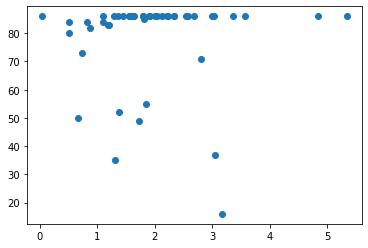

In [53]:
plt.scatter(x = hospital_data.sort_values('Hospital')['%PlannedCapacity'], y = Completeness.sort_index());

Naturally, 86 months is a long time. So let's take compare hospitals with more focus: What % of their planned operations did they have to cancel due to capacity in 2022?

The 5 hospitals with the highest % of Operations getting cancelled for capacity reasons are:     %PlannedCapacity                            Location Hospital
14          9.246902         Royal Hospital for Children    G513H
2           8.750000            Borders General Hospital    B120H
17          8.467742                   Raigmore Hospital    H202H
24          8.018328  Royal Aberdeen Children's Hospital    N121H
16          6.624606          Caithness General Hospital    H103H

The 5 hospitals with the lowest % of Operations getting cancelled for capacity reasons are:     %PlannedCapacity                     Location Hospital
38          0.000000  Galloway Community Hospital    Y144H
25          0.000000  Aberdeen Maternity Hospital    N161H
23          0.507185     Woodend General Hospital    N102H
40          0.565504                          NaN    Y177C
35          0.589623          Stracathro Hospital    T312H

There are 42 hospitals in the dataset.


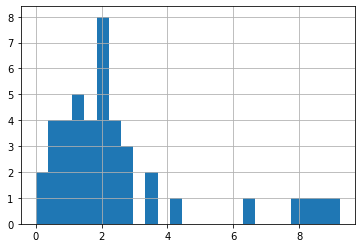

In [54]:
hospital_data_22 = data[data['Year'] == 2022]
hospital_data_22 = hospital_data_22.groupby(by = ['Hospital']).sum()
hospital_data_22 = hospital_data_22.drop('Year', axis = 1)
hospital_data_22 = pd.merge(hospital_data_22, hospital_names, how = 'left', on = 'Hospital')

hospital_data_22['%PlannedCapacity'] = (hospital_data_22['NonClinicalCapacityReason']/hospital_data_22['TotalOperations'])*100
print('The 5 hospitals with the highest % of Operations getting cancelled for capacity reasons are:', hospital_data_22.sort_values(by = '%PlannedCapacity', ascending = False).head()[['%PlannedCapacity','Location', 'Hospital']])
print('')
print('The 5 hospitals with the lowest % of Operations getting cancelled for capacity reasons are:', hospital_data_22.sort_values(by = '%PlannedCapacity', ascending = True).head()[['%PlannedCapacity','Location', 'Hospital']])
print('')
hospital_data_22['%PlannedCapacity'].hist(bins = 25);
print('There are', hospital_data_22.shape[0], 'hospitals in the dataset.')

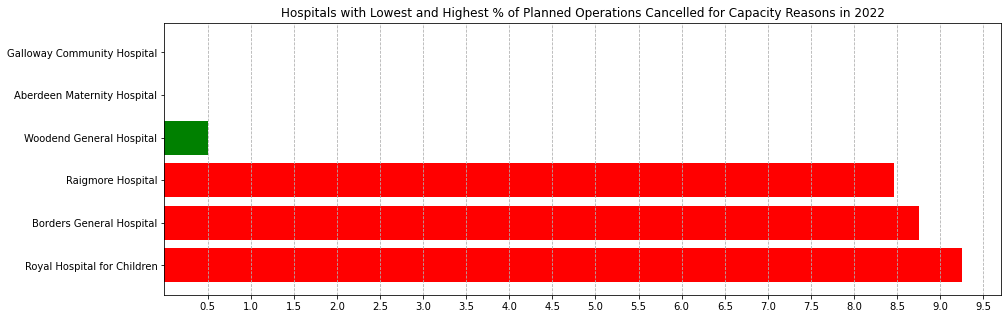

In [55]:
bot3_22 = hospital_data_22['%PlannedCapacity'].nlargest(3)
top3_22 = hospital_data_22['%PlannedCapacity'].nsmallest(3)
Extremes_22 = pd.concat([top3_22,bot3_22])
Extremes_22 = pd.concat([Extremes_22, hospital_data_22['Location']], axis = 1, join = 'inner').sort_values('%PlannedCapacity', ascending = False)
plt.figure(figsize = (15,5))
graph = plt.barh(y = Extremes_22['Location'], width = Extremes_22['%PlannedCapacity'], color = ['red', 'red', 'red','green', 'green', 'green' ])
plt.grid(axis = 'x', which = 'both', linestyle = '--')
plt.title('Hospitals with Lowest and Highest % of Planned Operations Cancelled for Capacity Reasons in 2022')
plt.xticks([0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5])
plt.show()

This time we see even more extreme differences than when looking at the last 7 years: While Galloway Community Hospital and Aberdeen Maternity Hospital didn't have a single cancellation due to capacity reasons, nearly 1/10th of all planned operations were cancelled at the Royal Hospital for children in Glasgow. Looking at the distribution we can actually see that most hospitals had to cancel less than 3% of their planned operations due to capacity reasons, and only a few hospitals performed really badly. It is safe to say though, that it does make a difference which hospital you visit.
Finally let's examine which hospitals are improving, and which are getting worse. We'll do this first by comparing their May 2022 data against May 2015 and then against May 2021.

LocationName
Borders General Hospital      -6.448769
Western Isles Hospital        -5.882353
Galloway Community Hospital   -4.132231
Ninewells Hospital            -2.984690
NaN                           -2.747253
Name: %PlannedCapacity, dtype: float64

LocationName
Royal Hospital for Children           13.333102
Royal Aberdeen Children's Hospital     8.282999
Victoria Hospital                      3.769466
Caithness General Hospital             3.573285
Belford Hospital                       2.857143
Name: %PlannedCapacity, dtype: float64


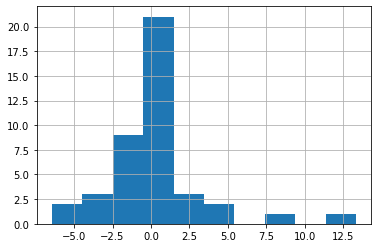

In [56]:
comp_data = data
comp_data = comp_data.set_index('LocationName')
comp_data['%PlannedCapacity'] = (comp_data['NonClinicalCapacityReason']/comp_data['TotalOperations'])*100
May2015 = comp_data[comp_data['Month'] == '201505']
May2015 = May2015['%PlannedCapacity']
May2022 = comp_data[comp_data['Month'] == '202205']
May2022 = May2022['%PlannedCapacity']
Difference = May2022 - May2015
print(Difference.nsmallest(5))
print('')
print(Difference.nlargest(5))
Difference.hist();

LocationName
Royal Hospital for Children and Young People   -1.784398
Dr Gray's Hospital                             -1.707159
University Hospital Ayr                        -1.328370
Stracathro Hospital                            -1.255791
Galloway Community Hospital                    -0.917431
Name: %PlannedCapacity, dtype: float64

LocationName
Royal Hospital for Children           11.271140
Royal Aberdeen Children's Hospital     9.032502
Raigmore Hospital                      5.644520
Belford Hospital                       5.000000
Caithness General Hospital             4.054054
Name: %PlannedCapacity, dtype: float64


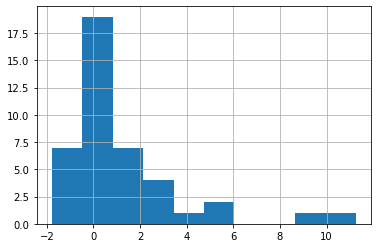

In [57]:
May2021 = comp_data[comp_data['Month'] == '202105']
May2021 = May2021['%PlannedCapacity']
May2022 = comp_data[comp_data['Month'] == '202205']
May2022 = May2022['%PlannedCapacity']
Difference = May2022 - May2021
print(Difference.nsmallest(5))
print('')
print(Difference.nlargest(5))
Difference.hist();

For both of these comparisons we can see that most hospitals' performance did not change by a lot. The situation at the Royal Hospital for Children in Glasgow and the Royal Aberdeen Children's Hospital in particular has gotten a lot worse, and their % of planned operations which are due to capacity has increased by 11.3 and 9 percentage points respectively compared to May 2021 (note that this does not mean it has increased by 11.3% and 9%, but rather that the new percentage value is 11.3 and 9 points higher) and by 13.3 and 8.3 points compared to May 2015. 

Any decreases in the % of planned operations cancelled due to capacity from May 2021 to May 2022 were small, but 2 hospitals managed to improve their performance in this statistic by over 5 points compared to 2015.

## 6. Can we predict how your hospital will do next month?

Having analysed how hospitals are performing at present and compared that to the past, the next logical step is to look into the future: can we predict how a certain hospital will do in the month to come?

The first thing we have to do for that is to introduce the metric we are looking to produce into the dataset. 

In [58]:
data['%PlannedCapacity'] = (data['NonClinicalCapacityReason']/data['TotalOperations'])*100

Next, let's examine the dataset with regards to what features we have at our disposal. We need any data we use in the prediction to be available at the point of time we are making the prediction. This means we will have to be working with lag data. We also have the information on the hospital, the month and year. Other geographical information such as the health board are available, but we can expect that any information they might add are already contained in the hospital. 
Realistically therefore, the features used in our model will be lag values of the target variable, % of planned operations to be cancelled for capacity reasons, as well as well as timestamp and hospital data. 
As we are dealing with time-series information, it will also be useful to examine the data for seasonality:

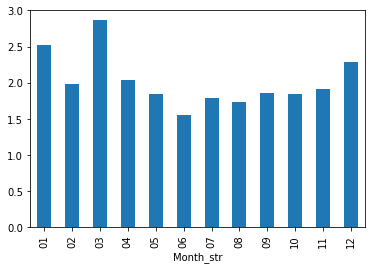

In [59]:
data.groupby('Month_str').mean()['%PlannedCapacity'].plot(kind = 'bar');

It does indeed look like there is some seasonality in the % of operations which have to be cancelled for capacity reasons. We should take this into account when choosing how many lag values to include.

#### 1. Set up the necessary functions


In [60]:
# 1. Select only the target variable & information on the hospital & Month as they will be the features included in the model
lag_data = data[['%PlannedCapacity', 'Month', 'Hospital', 'Year']]
#lag_data['Month'] = lag_data['Month'].astype('str')
# 2. Introduce lag data
def get_lag_data(data, target, nlags):

    data = data.sort_values(by = ['Hospital','Month'])
    for h in range(0,nlags) :
        i = h+1
        col_name = 'lag'+str(i)
        data[col_name] = data[target].shift(periods = i)
    data = data.dropna(axis = 0)
    return data

Before moving on, we will have to decide which modelling technique we will want to use as this will influence how we have to prepare our data. As we are looking for a numerical output, we will go with a simple linear regression model. Naturally, there are many different model types and techniques out there, some of which might be better suited. But we will keep it simple on this modelling attempt.

This means we have to figure out what to do with our categorical variables, Hospital, and the Month (as year & Month). As we will need them to later be able to identify where our data belong to, we will move them into the index, and then set up a function to either dummyfy or drop them depending on the input given.

In [61]:
# 2. Dealing with categorical variables

def cat_variables(data, dummyfy):
    dum_data = data.set_index(['Hospital', 'Month'], drop = False)
    cat_cols = dum_data.select_dtypes(include = 'object').columns
    if dummyfy == True:
        
        for col in cat_cols:
            dum_data = pd.concat([dum_data.drop(col, axis =1), pd.get_dummies(dum_data[col], prefix = col)], axis =1)
            
            
    else:
        dum_data.drop(cat_cols, axis = 1, inplace = True)
    
        
    return dum_data

We will use the 2022 data as our test set and use the data from 2015 to 2021 to train the model. Since this is time series data it makes sense to manually choose a cut-off date rather than randomly split the data into groups. As we discovered in our earlier analysis that there are no discernable trends in the data over time, using older data to train a model to make predictions for 2022 should not be an issue.

In [62]:
def splitting_data(data):
    test = data[data['Year'] == 2022]
    train = data[data['Year'] != 2022]

    y_test = test['%PlannedCapacity']
    X_test = test.drop('%PlannedCapacity', axis=1)

    y_train = train['%PlannedCapacity']
    X_train = train.drop('%PlannedCapacity', axis = 1)
    
    return y_test,y_train,X_test,X_train
    

Finally, we will define a function to prepare the data using the above defined functions and fit the model to them. We will also evaluate the model using the Root Mean Squared Error and the r squared score.

In [63]:
# 3. Set Up Model building function 
def cancellation_predictor(data, target, nlags, dummyfy):
    
    model_data = get_lag_data(data, target, nlags)
    
    model_data = cat_variables(model_data, dummyfy)
   
    y_test, y_train, X_test, X_train = splitting_data(model_data)
    

    Model = LinearRegression(normalize = True)
    Model.fit(X_train, y_train)
    
    preds_test = Model.predict(X_test)
    preds_train = Model.predict(X_train)
    
    r2_test = r2_score(y_test, preds_test)
    r2_train = r2_score(y_train, preds_train)
    
    RMSE_test = mean_squared_error(y_test, preds_test, squared = False)
    RMSE_train = mean_squared_error(y_train, preds_train, squared = False)
    
    return y_test, y_train, X_test, X_train, Model, preds_train, preds_test, r2_train, r2_test, RMSE_train, RMSE_test
    

As we saw that there is seasonality in our data, we will run the first two attempts with 12 months lag to capture the seasonality. We will try once with dummy variables and once without.

In [64]:
y_test, y_train, X_test, X_train, Model, preds_train, preds_test, r2_train, r2_test, RMSE_train, RMSE_test = cancellation_predictor(lag_data, '%PlannedCapacity', 12, False)

In [65]:
print('Test R2 =', r2_test)
print('Train R2 =', r2_train)
print('Test RMSE =', RMSE_test)
print('Train RMSE =', RMSE_train)

Test R2 = 0.25058372723316535
Train R2 = 0.1080412865688426
Test RMSE = 3.0210674621531113
Train RMSE = 2.7927747291391376


In [66]:
y_test2, y_train2, X_test2, X_train2, Model2, preds_train2, preds_test2, r2_train2, r2_test2, RMSE_train2, RMSE_test2 = cancellation_predictor(lag_data, '%PlannedCapacity', 12, True)

In [67]:
print('Test R2 =', r2_test2)
print('Train R2 =', r2_train2)
print('Test RMSE =', RMSE_test2)
print('Train RMSE =', RMSE_train2)

Test R2 = -9.111162158866655e+24
Train R2 = 0.21590233183270935
Test RMSE = 10533816580960.264
Train RMSE = 2.6184760802791973


We can see that the results aren't great. The RMSE is quite large compared the magnitude of values we see in the data themselves. The R_squared is also quite low which indicates that we aren't capturing the variance in the data too well. 
Let's try out different numbers of lag values with and without dummy variables and see which combination performs best.

    nlag  dummified          RMSE            R2
17     9      False  2.990093e+00  2.658721e-01
19    10      False  2.993062e+00  2.644135e-01
15     8      False  3.012002e+00  2.550745e-01
21    11      False  3.021039e+00  2.505979e-01
23    12      False  3.021067e+00  2.505837e-01
13     7      False  3.024221e+00  2.490185e-01
11     6      False  3.064308e+00  2.289773e-01
9      5      False  3.102662e+00  2.095556e-01
7      4      False  3.106464e+00  2.076174e-01
5      3      False  3.125580e+00  1.978354e-01
3      2      False  3.192007e+00  1.633765e-01
1      1      False  3.249071e+00  1.331963e-01
22    12       True  1.053382e+13 -9.111162e+24
16     9       True  3.469270e+13 -9.882767e+25
0      1       True  6.176805e+13 -3.132781e+26
10     6       True  6.823304e+13 -3.822890e+26
18    10       True  7.523331e+13 -4.647534e+26
14     8       True  9.330878e+13 -7.149034e+26
4      3       True  1.014305e+14 -8.447715e+26
8      5       True  1.195668e+14 -1.173

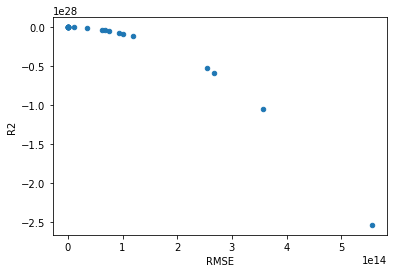

In [68]:
poss_dumm_vals = [True, False]
lags = []
dumm = []
RMSEs = []
r2s = []
for i in range(1,13):
    for j in poss_dumm_vals:
        y_test, y_train, X_test, X_train, Model, preds_train, preds_test, r2_train, r2_test, RMSE_train, RMSE_test = cancellation_predictor(lag_data, '%PlannedCapacity', i, j)
        lags.append(i)
        dumm.append(j)
        RMSEs.append(RMSE_test)
        r2s.append(r2_test)
        
models = pd.DataFrame(data = {'nlag':lags, 'dummified': dumm, 'RMSE': RMSEs, 'R2': r2s}).sort_values(by = 'RMSE')
print(models)
models.plot(x = 'RMSE', y = 'R2', kind = 'scatter');

This output shows us multiple things:
1. None of the models perform too well
2. Those without dummy variables do a lot better than those with
3. Amongst those models without dummy variables, higher lag values produce better results.


We could try and fit a different type of model: As we do not a lot of samples but quite a lot of features if we consider the lag data and dummy variables, a Support Vector Regression model could be expected to perform better. We will try with a liner SVR first



In [69]:
def cancellation_predictor_SVR(data, target='%PlannedCapacity', nlags = 12, dummyfy =  False, kernel ='linear', degree = 2, C = 1, gamma = 'scale'):
    
    model_data = get_lag_data(data, target, nlags)
    
    model_data = cat_variables(model_data, dummyfy)
   
    y_test, y_train, X_test, X_train = splitting_data(model_data)
    
    
    Model = SVR(kernel = kernel, degree = degree, C = C, gamma = gamma)
    Model.fit(X_train, y_train)
    
    preds_test = Model.predict(X_test)
    preds_train = Model.predict(X_train)
    
    r2_test = r2_score(y_test, preds_test)
    r2_train = r2_score(y_train, preds_train)
    
    RMSE_test = mean_squared_error(y_test, preds_test, squared = False)
    RMSE_train = mean_squared_error(y_train, preds_train, squared = False)
    
    return y_test, y_train, X_test, X_train, Model, preds_train, preds_test, r2_train, r2_test, RMSE_train, RMSE_test
    

    nlag  dummified      RMSE        R2
13     7      False  2.902535  0.308237
17     9      False  3.011518  0.255314
15     8      False  3.037201  0.242558
21    11      False  3.061425  0.230427
9      5      False  3.188339  0.165298
8      5       True  3.197175  0.160665
5      3      False  3.215490  0.151022
23    12      False  3.224243  0.146394
18    10       True  3.233123  0.141685
3      2      False  3.240528  0.137749
6      4       True  3.260273  0.127209
4      3       True  3.267276  0.123456
11     6      False  3.277729  0.117838
12     7       True  3.291171  0.110587
16     9       True  3.303962  0.103661
14     8       True  3.306190  0.102452
19    10      False  3.351659  0.077594
20    11       True  3.353329  0.076675
22    12       True  3.369285  0.067867
10     6       True  3.371246  0.066782
2      2       True  3.376572  0.063831
7      4      False  3.397827  0.052007
1      1      False  3.524760 -0.020144
0      1       True  3.590897 -0.058786


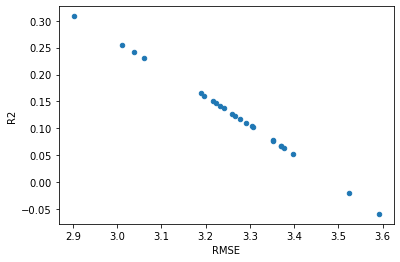

In [70]:
poss_dumm_vals = [True, False]
lags = []
dumm = []
RMSEs = []
r2s = []
for i in range(1,13):
    for j in poss_dumm_vals:
        y_test, y_train, X_test, X_train, Model, preds_train, preds_test, r2_train, r2_test, RMSE_train, RMSE_test = cancellation_predictor_SVR(lag_data, '%PlannedCapacity', i, j)
        lags.append(i)
        dumm.append(j)
        RMSEs.append(RMSE_test)
        r2s.append(r2_test)
        
models = pd.DataFrame(data = {'nlag':lags, 'dummified': dumm, 'RMSE': RMSEs, 'R2': r2s}).sort_values(by = 'RMSE')
print(models)
models.plot(x = 'RMSE', y = 'R2', kind = 'scatter');

In [76]:
y_test, y_train, X_test, X_train, Model, preds_train, preds_test, r2_train, r2_test, RMSE_train, RMSE_test = cancellation_predictor_SVR(lag_data, '%PlannedCapacity', 7, False)

In [72]:
print('Test R2 =', r2_test)
print('Train R2 =', r2_train)
print('Test RMSE =', RMSE_test)
print('Train RMSE =', RMSE_train)

Test R2 = 0.3082373450851075
Train R2 = 0.0759076938464689
Test RMSE = 2.9025346985858276
Train RMSE = 2.838660749779952


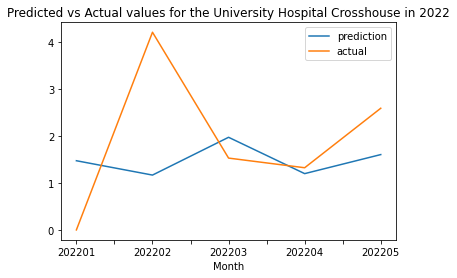

In [101]:
predictions = pd.DataFrame({'prediction':preds_test, 'actual':y_test}, index = y_test.index) 

predictions.loc[('A111H',),:].plot(title = 'Predicted vs Actual values for the University Hospital Crosshouse in 2022');


The train and test RMSE are pretty similar which suggests that there is no too strong overfitting going on. But the R squared is still pretty low and the RMSE quite high. Let's try with a different kernel.

    nlag  dummified      RMSE        R2
21    11      False  3.703798 -0.126411
23    12      False  3.703879 -0.126460
19    10      False  3.703897 -0.126471
17     9      False  3.704108 -0.126600
15     8      False  3.704377 -0.126763
20    11       True  3.704389 -0.126770
22    12       True  3.704532 -0.126857
16     9       True  3.704550 -0.126868
18    10       True  3.704607 -0.126903
14     8       True  3.705472 -0.127429
13     7      False  3.705507 -0.127450
12     7       True  3.706464 -0.128033
11     6      False  3.706718 -0.128188
10     6       True  3.707795 -0.128843
9      5      False  3.708309 -0.129157
7      4      False  3.709488 -0.129874
8      5       True  3.709515 -0.129891
5      3      False  3.710589 -0.130545
6      4       True  3.710714 -0.130621
4      3       True  3.712036 -0.131428
3      2      False  3.712390 -0.131643
1      1      False  3.713596 -0.132378
2      2       True  3.713968 -0.132605
0      1       True  3.715294 -0.133414


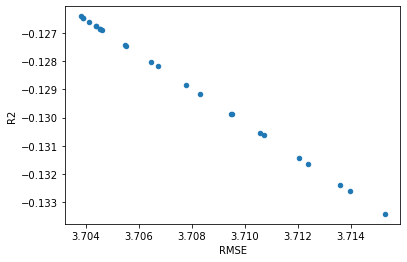

In [73]:
poss_dumm_vals = [True, False]
lags = []
dumm = []
RMSEs = []
r2s = []
for i in range(1,13):
    for j in poss_dumm_vals:
        y_test, y_train, X_test, X_train, Model, preds_train, preds_test, r2_train, r2_test, RMSE_train, RMSE_test = cancellation_predictor_SVR(lag_data, '%PlannedCapacity', i, j, kernel = 'rbf')
        lags.append(i)
        dumm.append(j)
        RMSEs.append(RMSE_test)
        r2s.append(r2_test)
        
models = pd.DataFrame(data = {'nlag':lags, 'dummified': dumm, 'RMSE': RMSEs, 'R2': r2s}).sort_values(by = 'RMSE')
print(models)
models.plot(x = 'RMSE', y = 'R2', kind = 'scatter');

This does not improve the model we got from the linear SVR. Trying the polynomial kernel also brought no improvement. One option for further model improvement would be to perform a grid search. This, however, would become very computationally expensive.

We saw in our earlier analysis, that there are actually very big differences between hospitals. One option would therefore be to find the optimal parameters for each hospital, and then fit the best models for each. Doing this across all hospitals would be very computationally expensive (I tried), but we can see if this would improve results by manually selecting a couple of hospitals to try it out on:

This clearly didn't work very well. Let's try for another hospital:

    nlag  dummified      RMSE        R2
17     9      False  0.529210  0.085900
2      2       True  0.705031 -0.622387
18    10       True  0.719557 -0.689928
4      3       True  0.721582 -0.699452
19    10      False  0.726988 -0.725014
0      1       True  0.727187 -0.725958
16     9       True  0.733865 -0.757800
8      5       True  0.735523 -0.765754
9      5      False  0.749148 -0.831776
6      4       True  0.750875 -0.840233
20    11       True  0.758318 -0.876899
5      3      False  0.759160 -0.881068
10     6       True  0.807616 -1.128862
14     8       True  0.815561 -1.170952
12     7       True  0.834146 -1.271023
15     8      False  0.844482 -1.327654
1      1      False  0.921146 -1.769458
23    12      False  0.935885 -1.858792
22    12       True  0.944101 -1.909209
3      2      False  0.952718 -1.962552
7      4      False  1.023589 -2.419709
21    11      False  1.051253 -2.607049
13     7      False  1.112224 -3.037586
11     6      False  1.159239 -3.386149


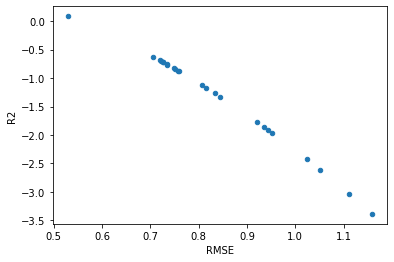

In [74]:
#Let's try this with H202H as we already know we have complete data for this one:

mod_data = lag_data[lag_data['Hospital'] == 'Z102H']
        
poss_dumm_vals = [True, False]
lags = []
dumm = []
RMSEs = []
r2s = []
for i in range(1,13):
    for j in poss_dumm_vals:
        y_test, y_train, X_test, X_train, Model, preds_train, preds_test, r2_train, r2_test, RMSE_train, RMSE_test = cancellation_predictor_SVR(mod_data, '%PlannedCapacity', i, j, kernel = 'linear')
        lags.append(i)
        dumm.append(j)
        RMSEs.append(RMSE_test)
        r2s.append(r2_test)
        
models = pd.DataFrame(data = {'nlag':lags, 'dummified': dumm, 'RMSE': RMSEs, 'R2': r2s}).sort_values(by = 'RMSE')
print(models)
models.plot(x = 'RMSE', y = 'R2', kind = 'scatter');

This looks a lot better in terms of RMSE, but still nowhere near where it could be called a good model. Mostly, the models appear to be underfitting. This is not very surprising given the little data we have available. More computationally expensive methods could be used, but the most improvement could probably be achieved by obtaining more data  on factors such as staffing levels, budget, etc.